# In Depth: k-Means Clustering

Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in ``sklearn.cluster.KMeans``.

We begin with the standard imports:

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

## Introducing k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


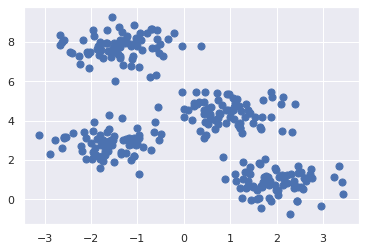

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)   #YOUR CODE HERE: implement K-means algorithm, set up 4 as number of clusters and fit K-means model.

y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

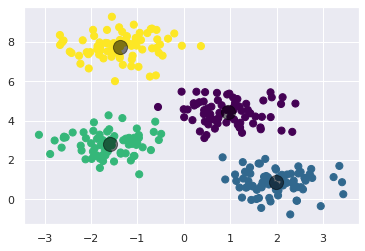

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## k-Means Algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
   1. *E-Step*: assign points to the nearest cluster center
   2. *M-Step*: set the cluster centers to the mean 

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.
For an interactive version of this figure, refer to the code in [the Appendix](06.00-Figure-Code.ipynb#Interactive-K-Means).

![(run code in Appendix to generate image)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.11-expectation-maximization.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Expectation-Maximization)

The *k*-Means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation:

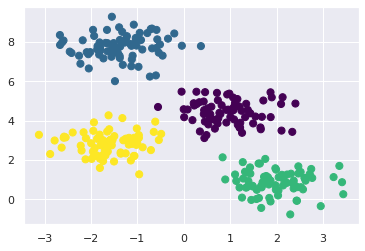

In [6]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

### Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

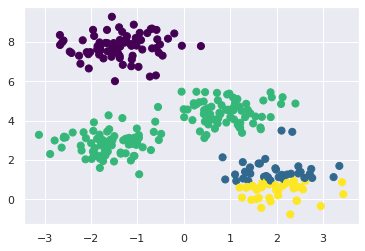

In [7]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

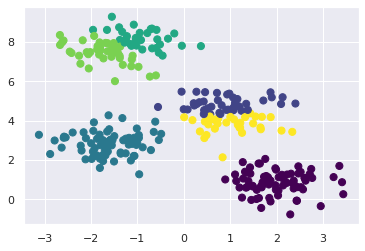

In [8]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models; see [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb)) or which *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the ``sklearn.cluster`` submodule)

#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

In [0]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

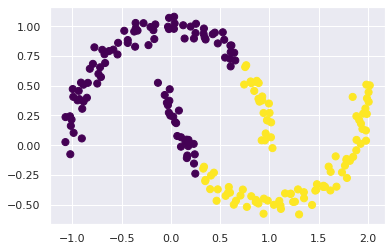

In [10]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

This situation is reminiscent of the discussion in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb), where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.
We might imagine using the same trick to allow *k*-means to discover non-linear boundaries.

One version of this kernelized *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm:

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


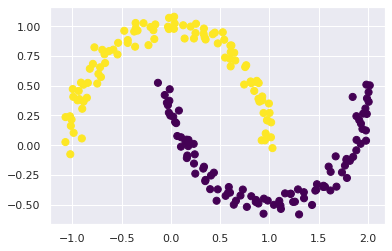

In [11]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

#### k-means can be slow for large numbers of samples
Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.
This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in ``sklearn.cluster.MiniBatchKMeans``.
The interface for this is the same as for standard ``KMeans``; we will see an example of its use as we continue our discussion.

## Examples

Being careful about these limitations of the algorithm, we can use *k*-means to our advantage in a wide variety of situations.
We'll now take a look at a couple examples.

### Example: k-means on digits

To start, let's take a look at applying *k*-means on the same simple digits data that we saw in [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) and [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb).
Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.

We will start by loading the digits and then finding the ``KMeans`` clusters.
Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [12]:
from sklearn.datasets import load_digits
digits =load_digits() #YOUR CODE HERE
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [13]:
kmeans = KMeans(n_clusters=10, random_state=0) #YOUR CODE HERE, set up 10 as number of clusters and 0 as parameter for random_state 
clusters = kmeans.fit_predict(digits.data) #YOUR CODE HERE, fit K-means model
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.
Let's see what these cluster centers look like:

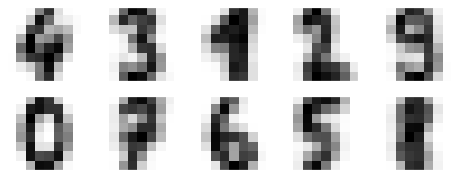

In [14]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because *k*-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in them:

In [0]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels) #YOUR CODE HERE

0.7952142459654981

With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!
Let's check the confusion matrix for this:

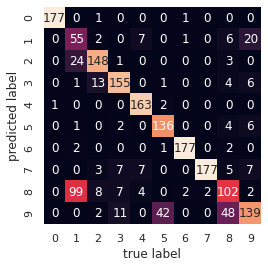

In [19]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels) #YOUR CODE HERE, build confusion materix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.
But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!

Just for fun, let's try to push this even farther.
We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm (mentioned in [In-Depth: Manifold Learning](05.10-Manifold-Learning.ipynb)) to pre-process the data before performing *k*-means.
t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.
Let's see how it does:

In [21]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0) #YOUR CODE HERE, set up 10 as number of clusters and 0 as parameter for random_state 
clusters = kmeans.fit_predict(digits_proj) #YOUR CODE HERE, fit K-means model

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels) #YOUR CODE HERE

0.9371174179187535

That's nearly 92% classification accuracy *without using the labels*.
This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to do by hand or by eye.

# In Depth: Gaussian Mixture Models

The *k*-means clustering model explored in the previous section is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application.
In particular, the non-probabilistic nature of *k*-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.
In this section we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind *k*-means, but can also be a powerful tool for estimation beyond simple clustering.

We begin with the standard imports:

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating GMM: Weaknesses of k-Means

Let's take a look at some of the weaknesses of *k*-means and think about how we might improve the cluster model.
As we saw in the previous section, given simple, well-separated data, *k*-means finds suitable clustering results.

For example, if we have simple blobs of data, the *k*-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [0]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

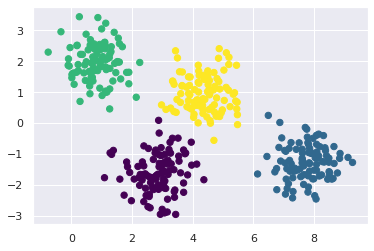

In [24]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)#YOUR CODE HERE, set up 4 as number of clusters and 0 as parameter for random_state 
labels = kmeans.fit(X).predict(X) #YOUR CODE HERE, fit K-means model
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them.
Unfortunately, the *k*-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
For this, we must think about generalizing the model.

One way to think about the *k*-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.
This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.
We can visualize this cluster model with the following function:

In [0]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

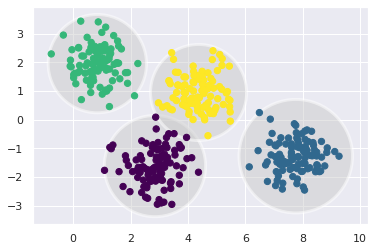

In [26]:
kmeans = KMeans(n_clusters=4, random_state=0)#YOUR CODE HERE
plot_kmeans(kmeans, X)

An important observation for *k*-means is that these cluster models *must be circular*: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

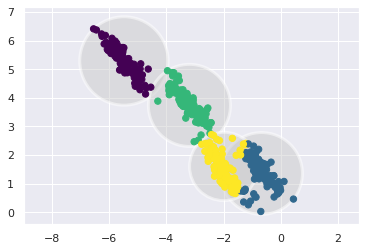

In [27]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0) #YOUR CODE HERE, set up 4 as number of clusters and 0 as parameter for random_state 
plot_kmeans(kmeans, X_stretched)

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit.
Nevertheless, *k*-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.
This results in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot.
One might imagine addressing this particular situation by preprocessing the data with PCA (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)), but in practice there is no guarantee that such a global operation will circularize the individual data.

These two disadvantages of *k*-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

You might imagine addressing these weaknesses by generalizing the *k*-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest.
You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.
It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.

## Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

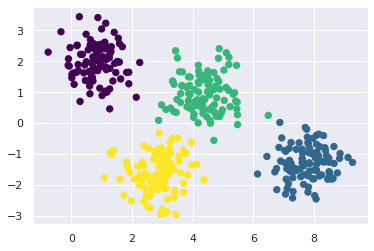

In [28]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [29]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.469 0.531 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

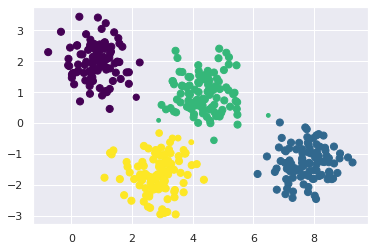

In [30]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [0]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

With this in place, we can take a look at what the four-component GMM gives us for our initial data:

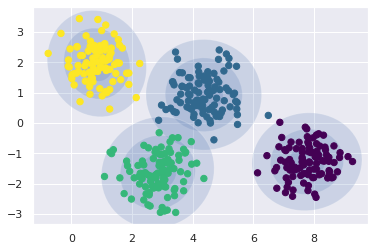

In [32]:
gmm = GMM(n_components=4, random_state=42) #YOUR CODE HERE, set up 4 as number of mixture components and 42 as parameter for random_state 
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

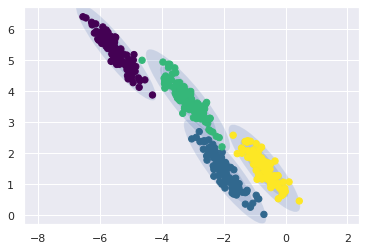

In [33]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.

### Choosing the covariance type

If you look at the details of the preceding fits, you will see that the ``covariance_type`` option was set differently within each.
This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
The default is ``covariance_type="diag"``, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is ``covariance_type="spherical"``, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"``, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

We can see a visual representation of these three choices for a single cluster within the following figure:

![(Covariance Type)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.12-covariance-type.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Covariance-Type)

## GMM as *Density Estimation*

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's ``make_moons`` function, which we saw in [In Depth: K-Means Clustering](05.11-K-Means.ipynb):

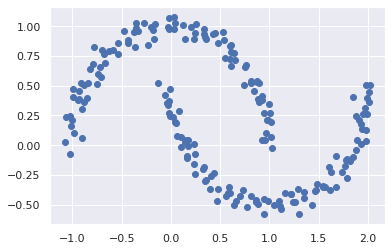

In [34]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

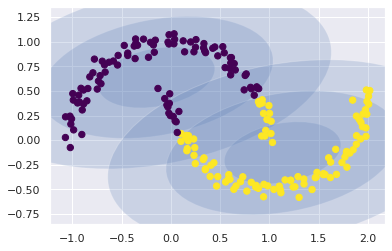

In [35]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

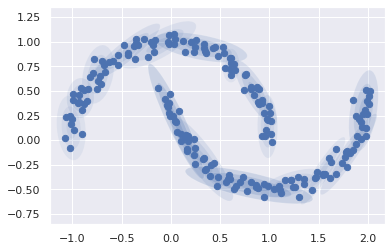

In [36]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.
For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

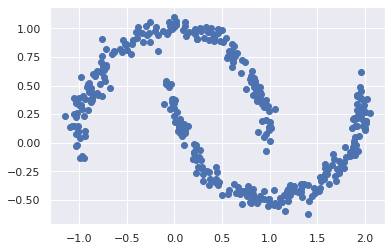

In [37]:
Xnew, _ = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

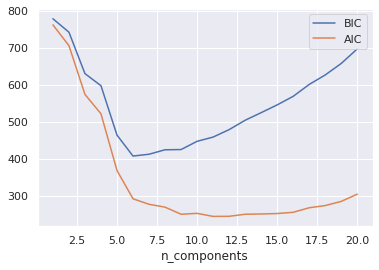

In [39]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]#YOUR CODE HERE

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

## Example: GMM for Generating New Data

We just saw a simple example of using GMM as a generative model of data in order to create new samples from the distribution defined by the input data.
Here we will run with this idea and generate *new handwritten digits* from the standard digits corpus that we have used before.

To start with, let's load the digits data using Scikit-Learn's data tools:

In [40]:
from sklearn.datasets import load_digits
digits = load_digits()#YOUR CODE HERE
digits.data.shape

(1797, 64)

Next let's plot the first 100 of these to recall exactly what we're looking at:

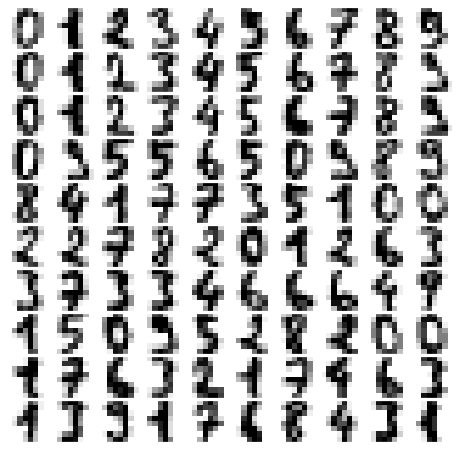

In [41]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

We have nearly 1,800 digits in 64 dimensions, and we can build a GMM on top of these to generate more.
GMMs can have difficulty converging in such a high dimensional space, so we will start with an invertible dimensionality reduction algorithm on the data.
Here we will use a straightforward PCA, asking it to preserve 99% of the variance in the projected data:

In [42]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data) #YOUR CODE HERE, fit PCA model
data.shape

(1797, 41)

The result is 41 dimensions, a reduction of nearly 1/3 with almost no information loss.
Given this projected data, let's use the AIC to get a gauge for the number of GMM components we should use:

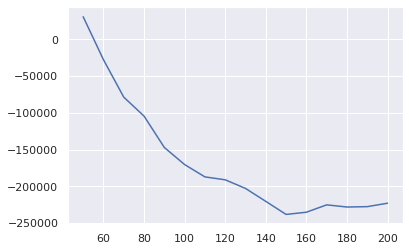

In [43]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

It appears that around 110 components minimizes the AIC; we will use this model.
Let's quickly fit this to the data and confirm that it has converged:

In [44]:
gmm = GMM(110, covariance_type='full', random_state=0)#YOUR CODE HERE
gmm.fit(data)
print(gmm.converged_)

True


Now we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model:

In [45]:
data_new, _ = gmm.sample(100)
data_new.shape

(100, 41)

Finally, we can use the inverse transform of the PCA object to construct the new digits:

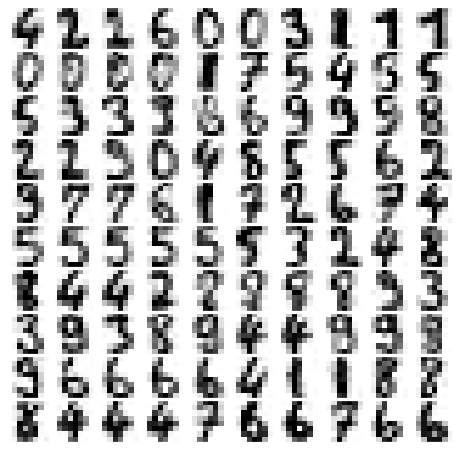

In [46]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

The results for the most part look like plausible digits from the dataset!

Consider what we've done here: given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data: these are "handwritten digits" which do not individually appear in the original dataset, but rather capture the general features of the input data as modeled by the mixture model.
Such a generative model of digits can prove very useful as a component of a Bayesian generative classifier, as we shall see in the next section.